In [200]:
import re
import numpy as np
import pandas as pd
from os import path
from collections import Counter
from glob import glob
from lxml import etree
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

In [256]:
df_corpus = pd.read_csv(r'../metadata/corpus.csv')
#df_meta_data = pd.read_csv(r'../metadata/meta_data_canons.csv')
df_meta_data = pd.read_csv(r'../metadata/meta_data_last_version.csv')
df_corpus_canon = pd.read_csv(r'../metadata/corpus_canons.csv')

#### Get list doc name & gender & auteur_canon from metadata/corpus.csv

In [257]:
list_doc_name = df_corpus.doc_name
list_auteur = df_corpus.auteur
list_titre = df_corpus.titre
list_date = df_corpus.date
list_gender = df_corpus.gender
list_auteur_canon = df_corpus.canon

#### Get list roman_canon from metadata/corpus_canon.csv

In [258]:
list_roman_canon = df_corpus_canon.canon

#### Get lists presence in canon ? 0, 1 from metadata/meta_data_canons.csv

In [259]:
def get_list_presence_roman(list_titre, df_meta_data, feature_wanted):
    list_feature_wanted = []
    for elem in list_titre:
        if feature_wanted not in list(df_meta_data.columns):
            print('feature_wanted do not exist')
            return
        else :
            if elem in list(df_meta_data[feature_wanted]):
                list_feature_wanted.append(1)                
            else:
                list_feature_wanted.append(0)
    return list_feature_wanted

In [260]:
list_bac = get_list_presence_roman(list_titre, df_meta_data, 'bac')
list_brevet = get_list_presence_roman(list_titre, df_meta_data, 'brevet')
list_lm = get_list_presence_roman(list_auteur, df_meta_data, 'lm')
list_sup = get_list_presence_roman(list_titre, df_meta_data, 'sup')
list_prix = get_list_presence_roman(list_titre, df_meta_data, 'prix')
list_gf = get_list_presence_roman(list_titre, df_meta_data, 'gf')
list_pleiade = get_list_presence_roman(list_auteur, df_meta_data, 'pleiade')
list_gouv = get_list_presence_roman(list_titre, df_meta_data, 'gouv')

In [261]:
zipped = list(zip(list_doc_name, list_date, list_auteur, list_titre, list_roman_canon, list_auteur_canon, list_gender, list_bac, list_brevet, list_lm, list_sup, list_prix, list_gf, list_pleiade, list_gouv))

In [262]:
df_canon_spec = pd.DataFrame(zipped, columns=["doc_name", "date", "auteur", "titre", "canon_roman", "canon_auteur", "gender", "bac", "brevet", "lm", 'sup', 'prix', 'gf', 'pleiade', 'gouv'])

In [263]:
df_canon_spec.to_csv(r'../metadata/df_canon_spec_last.csv')

In [264]:
df_canon_NOVEL_SCALE = df_canon_spec[(df_canon_spec['bac']==1) | (df_canon_spec['brevet']==1) | (df_canon_spec['sup']==1) | (df_canon_spec['prix']==1) | (df_canon_spec['gf']==1) | (df_canon_spec['gouv']==1)]

In [265]:
df_canon_NOVEL_SCALE.to_csv(r'../metadata/df_canon_NOVEL_SCALE.csv')

In [281]:
len(df_canon_NOVEL_SCALE)

244

In [267]:
df_canon_AUTEUR_SCALE = df_canon_spec[(df_canon_spec['lm']==1) | (df_canon_spec['pleiade']==1) | (df_canon_spec['canon_auteur']==True)]

In [268]:
df_canon_AUTEUR_SCALE.to_csv(r'../metadata/df_canon_AUTEUR_SCALE.csv')

In [269]:
df_canon_spec.bac.value_counts()[1]

83

In [270]:
df_canon_spec.brevet.value_counts()[1]

43

In [271]:
df_canon_spec.sup.value_counts()[1]

35

In [272]:
df_canon_spec.prix.value_counts()[1]

73

In [273]:
df_canon_spec.gouv.value_counts()[1]

43

In [274]:
df_canon_spec.gf.value_counts()[1]

84

In [275]:
def prep_list_graph(df_canon_spec, list_factors):
    list_res_factors = []
    for col in df_canon_spec.columns:
        if col in list_factors:
            list_res_factors.append(df_canon_spec[col].value_counts()[1])
    return list_res_factors

In [276]:
list_factors = ["bac", "brevet", 'sup', 'prix', 'gf', 'gouv']

In [277]:
list_res_factors = prep_list_graph(df_canon_spec, list_factors)

C:\Users\jeanb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

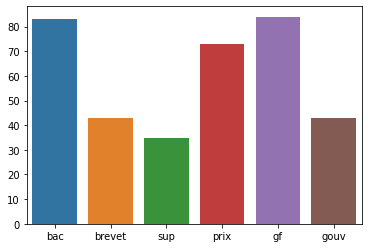

In [278]:
sns.barplot(list_factors, list_res_factors)

In [279]:
df_canon_spec.pleiade.value_counts()[1]

588

In [280]:
df_canon_spec.lm.value_counts()[1]

561

In [247]:
len(set(list(df_canon_spec.auteur)))

710

In [248]:
2961/710

4.170422535211268

In [159]:
len(set(list(df_canon_female.auteur)))

148

In [155]:
len(df_canon_female)/len(set(list(df_canon_female.auteur)))

4.222972972972973

<AxesSubplot:xlabel='pleiade', ylabel='lm'>

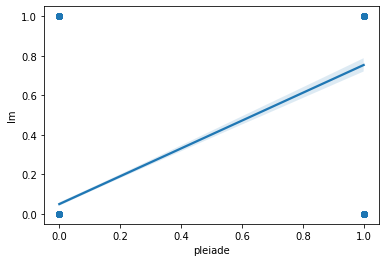

In [249]:
sns.regplot(data=df_canon_spec, x="pleiade", y="lm")

In [250]:
np.corrcoef(df_canon_spec['pleiade'], df_canon_spec['lm'])

array([[1.        , 0.71634589],
       [0.71634589, 1.        ]])

In [251]:
pearsonr(df_canon_spec['pleiade'], df_canon_spec['lm'])

(0.7163458882624895, 0.0)

<AxesSubplot:xlabel='gf', ylabel='bac'>

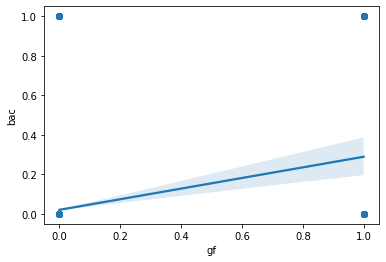

In [252]:
sns.regplot(data=df_canon_spec, x="gf", y="bac")

<AxesSubplot:xlabel='brevet', ylabel='sup'>

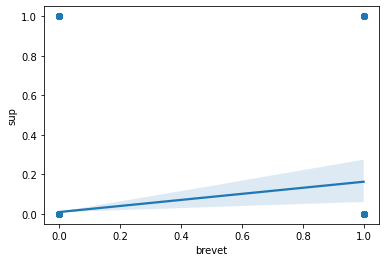

In [253]:
sns.regplot(data=df_canon_spec, x="brevet", y="sup")

In [254]:
np.corrcoef(df_canon_spec['gf'], df_canon_spec['gouv'])

array([[1.        , 0.35565507],
       [0.35565507, 1.        ]])